<a href="https://colab.research.google.com/github/JoseLuisHerme/Scientific_ML_Project/blob/main/Multivariate_Outlier_Detection_RealData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Title: AE-DBSCAN – An Outlier Detection Method on Multidimensional Tabular Datasets.


###By: Ademide (Midé) Mabadeje, Jose Hernandez Mejia, Stella FillmorePatrick

Let's install the packages needed for the code demonstrations below and import accordingly.

In [ ]:
# Import packages needed
import numpy as np
import pandas as pd
import random as rand
import copy
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

from torchvision import datasets
from torchvision import transforms

Declare and define the functions needed for computational ease.

In [ ]:
def norm(bhp_mon):
    """
    A function to normalize the input array on [0, 1] that returns a normalized 
    input array.

    Parameters

    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    test_norm=(bhp_mon-min_p)/(max_p-min_p)
    return test_norm

def inv_norm(norm_array,bhp_mon):
    """
    A function to invert the normalized input array back to its original scale 
    in Euclidean space.

    Parameters

    norm_array: a normalized nd-array 
    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    inv_norm=norm_array*(max_p-min_p)+min_p
    return inv_norm
    
def norm_2(norm_array,bhp_mon):
    """
    A function to normalize the input array based on a specific range or 
    different vector in Euclidean space on a scale of [0, 1]

    Parameters

    norm_array: a normalized nd-array 
    bhp_mon: an nd-array in the Euclidean space.
    """
    min_p=np.min(bhp_mon)
    max_p=np.max(bhp_mon)
    test_norm=(norm_array-min_p)/(max_p-min_p)
    return test_norm


def nearest_neighbor(X, Ax=None, Ay=None, T=None, plotter=True):
    """
    A function to find the most prevalent intersampling distance (lag dist) in 
    an array
    
    Parameters
    X: an array of the dataset consisting of a point sets location vectors
    """
    
    # Input preparation
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    # get nominal distance between samples such that it can be used as lag_distance input
    lag_dist = np.mean(distances)

    if plotter:
      # Make figure
      plt.plot(distances, c='black')
      plt.xlabel('Sorted Ascending, Data Index')
      plt.ylabel('Intersample Distance in LS')
      plt.title('Nearest Neighbour ')
      plt.plot(Ax, Ay, color='black', linestyle='--')
      plt.text(T[0], T[1], r'Elbow location with optimal epsilon', size=10)
      plt.savefig('Eps determination in LS using NN.tiff', dpi=300, bbox_inches='tight')
      plt.show()
    return lag_dist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing real dataset and split into categorial and continous variables and remove NaN values

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/rodpump_failure 2.csv')

cont_var=df.iloc[:,[5,6,7,8,10,11,12,13,14,15,16,17,20,21,22,23,24]].to_numpy()
cat_var=df.iloc[:,[4,9,18,19]]



red_var=cont_var[:,[0,1,2,3,5,6,7,8,9,10,15,16]]
indices = ~np.isnan(red_var).any(axis=1)
filtered_arr = red_var[indices]


Vizualize the bivariate correlation coefficient and vizualize it in a heatmap

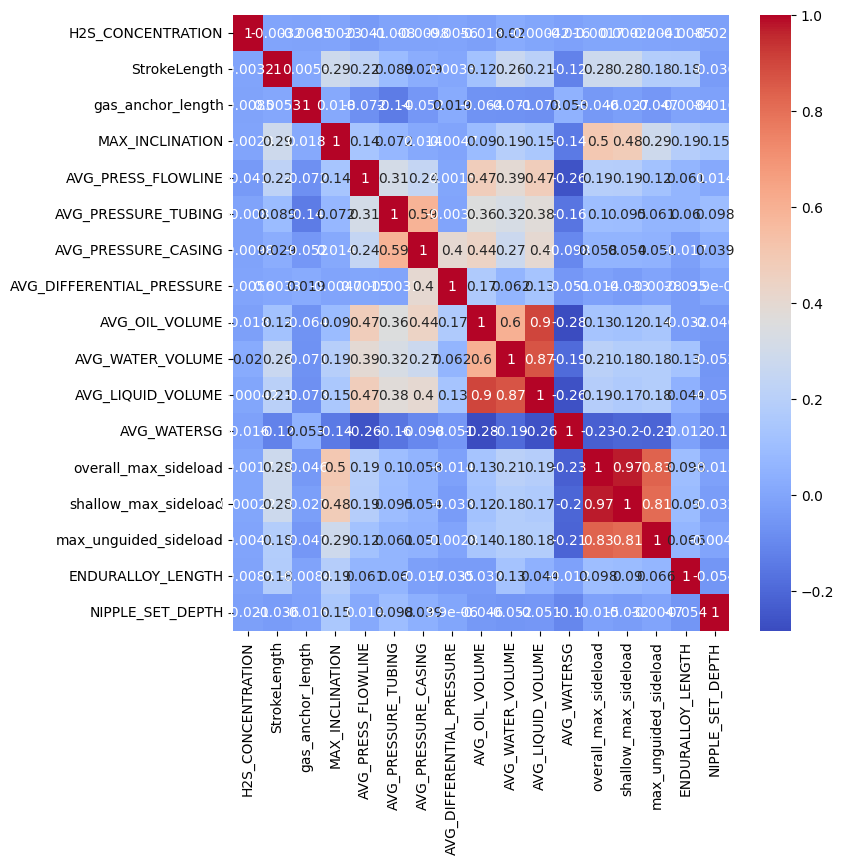

In [ ]:
# Make correlation heatmap for all predictors 
cont_var=df.iloc[:,[5,6,7,8,10,11,12,13,14,15,16,17,20,21,22,23,24]]
corr_matrix = cont_var.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

Select variables to apply AE-DBSCAN for anomaly detection

In [ ]:
# Obtain heatmap for select predeictors that have the most impact on the response feature
red_con=cont_var.iloc[:,[4,5,6,8,9]].to_numpy()
indices = ~np.isnan(red_con).any(axis=1)
red_arr = red_con[indices]

In [ ]:
X=red_arr
X_n=norm(X)
print(f'X shape = {X_n.shape}')

X shape = (1649, 5)


Split the synthetic multidimensional dataset into test and train sets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_n, X_n, test_size=0.20, random_state=42)

Affix the random seed in Pytorch to ensure reproducible results.

In [ ]:
seed = 78703
torch.manual_seed(seed)

Prepare the synthetic dataset such that it is in a Pytorch accepted format with the earlier test-train split sets. 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

dataset_train = GaussianDataset(X=X_train, device=device)
dataset_test = GaussianDataset(X=X_test, device=device)
data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, num_workers=1)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=True, num_workers=1)


cpu


Build the Autoencoder (AE) architecture as needed using feed-forward layers.

In [ ]:
class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 2)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded



Initialize the AE model and specify trhe loss function and optimizer to use i.e., MSE and ADAM respectively.

In [ ]:
model = AE(input_size=X.shape[1]).double().to(device)
loss_function = torch.nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Train the built AE over a large number of epochs such that it is well trained and would work well at reconstructing X = X' in the test set.

In [ ]:
epochs = 50
history = dict(train=[], val=[])
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 10000.0

for epoch in range(epochs):
    model = model.train()
    train_losses = []

    for (items, _) in data_loader_train:
        optimizer.zero_grad()
        items = items.to(device)

        reconstructed = model(items)
        loss = loss_function(reconstructed, items)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().cpu().numpy().item())

    train_losses = np.array(train_losses)

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for (items, _) in data_loader_test:

        items = items.to(device)
        reconstructed = model(items)
        loss = loss_function(reconstructed, items)

        val_losses.append(loss.detach().cpu().numpy().item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

    model.load_state_dict(best_model_wts)

Epoch 0: train loss 0.0007613708858309007 val loss 0.0003539465754180886
Epoch 1: train loss 0.0005972236772957513 val loss 0.00020842162821547872
Epoch 2: train loss 0.000415513835476034 val loss 0.0005255183860086642
Epoch 3: train loss 0.00037208080366450783 val loss 0.00026256961997112656
Epoch 4: train loss 0.000445522534911928 val loss 0.00020772432695607892
Epoch 5: train loss 0.0003318945549655376 val loss 0.0004461117553775854
Epoch 6: train loss 0.0003146059671038133 val loss 0.00020082342081383434
Epoch 7: train loss 0.00030231238831062194 val loss 0.00020854545453312138
Epoch 8: train loss 0.00039214985360878587 val loss 0.00020187413902101703
Epoch 9: train loss 0.000351624876748253 val loss 0.00022733996292635138
Epoch 10: train loss 0.0004055842851300486 val loss 0.0002143055145390365
Epoch 11: train loss 0.00033533386064861666 val loss 0.00021555668055940326
Epoch 12: train loss 0.0004833619810531748 val loss 0.0002351570830213344
Epoch 13: train loss 0.0003825866009420

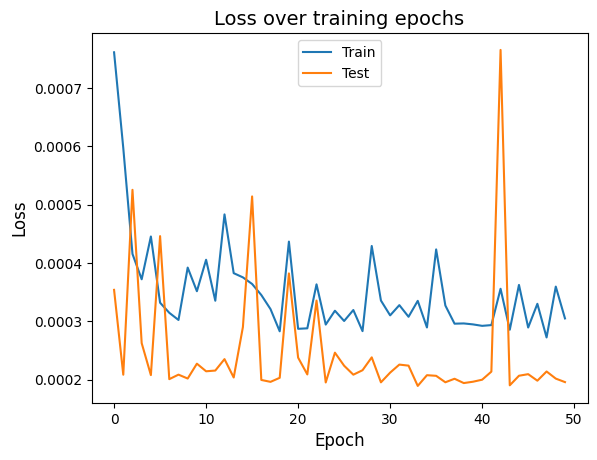

In [ ]:
MODEL_PATH = 'ML_anomality_detection.pth'

torch.save(model, MODEL_PATH)
ax = plt.figure().gca()
ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Test'])
plt.title('Loss over training epochs', fontsize=14)
plt.savefig("Loss over training epochs same random population for real data.tiff", dpi=300)
plt.show();

Measure the reconstruction error on the predictor features to see if X_test = (X_test)' or by how much it differs.

In [ ]:
test_score=[]
test_pred=[]
test_real=[]
for j in range(X_test.shape[0]):
  test=torch.tensor(X_test[j]).to(device)
  pred=model(test).detach().cpu().numpy()

  inv_pred=inv_norm(pred,X)
  test_pred.append(inv_pred)

  inv_test=inv_norm(X_test[j],X)
  test_real.append(inv_test)

  mse=mean_squared_error(inv_test,inv_pred)
  test_score.append(mse)

test_score=np.array(test_score)
test_pred=np.array(test_pred)
test_real=np.array(test_real)

In [ ]:
mse_model=mean_squared_error(test_real,test_pred)
print (mse_model)

1020.5367507406456


Visualize the predicted values with the actual values and compare using a 45 degree line as a measure of total accuracy if data points lie exactly on it.

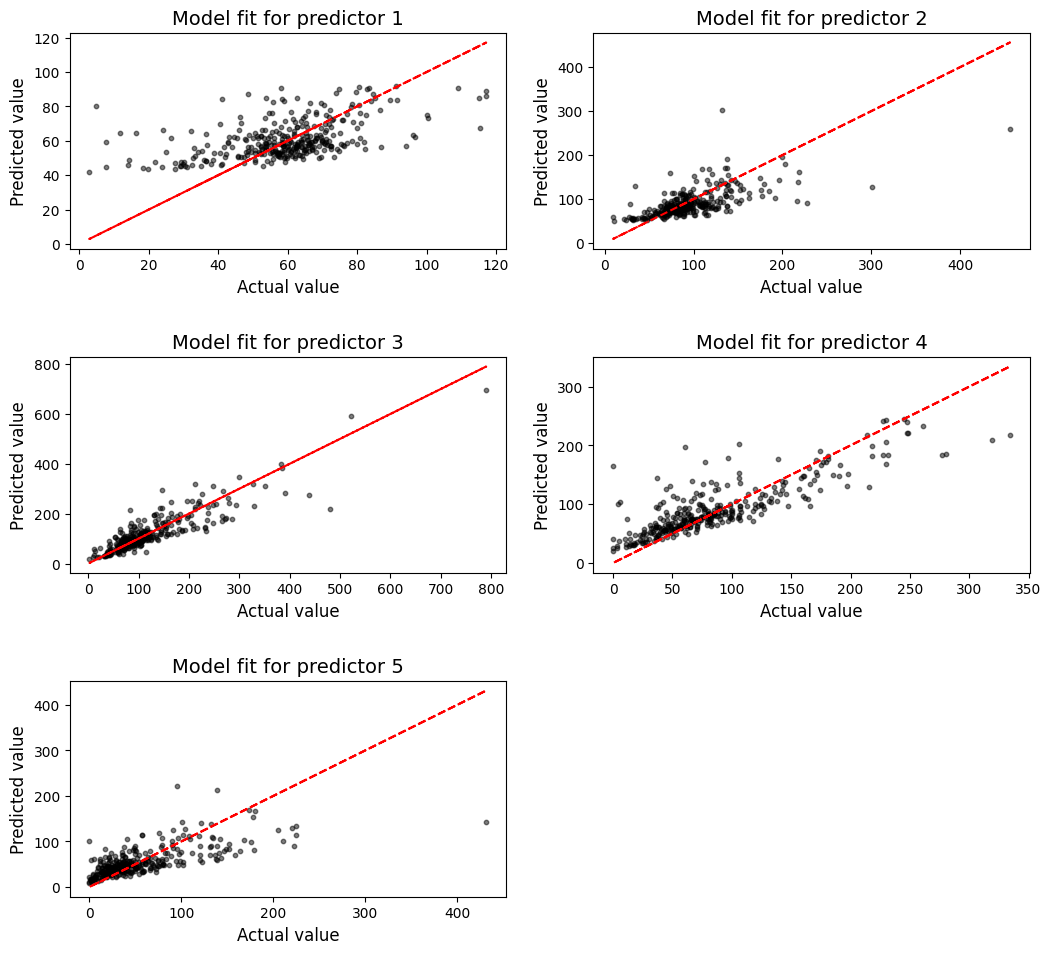

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2)

for k, ax in enumerate(axs.flatten()):
  if k == 5:
    ax.set_visible(False)
  else:
    ax.scatter(test_real[:,k],test_pred[:,k], alpha=0.5, color='k', s=10)
    ax.plot(test_real[:,k],test_real[:,k], color='red', linestyle='--')
    ax.set_xlabel('Actual value', fontsize=12)
    ax.set_ylabel('Predicted value', fontsize=12)
    ax.set_title(f"Model fit for predictor {k+1}", fontsize=14)

plt.savefig("Model fit over same random population for real data.tiff", dpi=300)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.8, wspace=0.2, hspace=0.5)
plt.show();

In [ ]:
output = inv_pred
input = inv_test

print('The reconstructed input, output differs from the original AE input by the following differences: ' , np.round(input-output,4), '\n, hence we do not have perfect reconstruction between the input and output')

The reconstructed input, output differs from the original AE input by the following differences:  [-22.8701 -27.4068   7.3619  25.7128 -20.9309] 
, hence we do not have perfect reconstruction between the input and output


In [ ]:
print('The array for the input is: ', np.round(inv_test, 4))
print('The array for the output is: ', np.round(inv_pred, 4))

The array for the input is:  [33.1972 49.5814 95.7893 97.1147 19.8325]
The array for the output is:  [56.0673 76.9881 88.4274 71.4019 40.7634]


Obtain the data projections in the latent space 

In [ ]:
latent_space=[]
mse_dst=[]
for i in range(X_n.shape[0]):
  test=torch.tensor(X_n[i]).to(device)

  lat=model.encoder(test).detach().cpu().numpy()
  latent_space.append(lat)

  pred=model(test).detach().cpu().numpy()
  
  inv_pred=inv_norm(pred,X)
  inv_test=inv_norm(X_n[i],X)

  mse=mean_squared_error(inv_test,inv_pred)
  mse_dst.append(mse)

latent_space=np.array(latent_space)
mse_dst=np.array(mse_dst)

Visualize the latent space with the originally trained dataset.

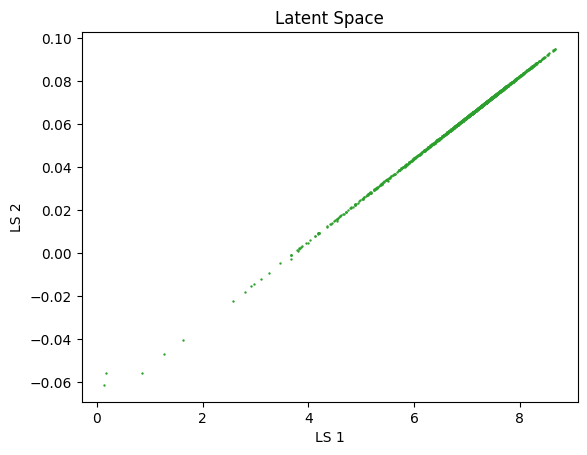

In [ ]:
#Visualize latent space with originally trained data
plt.title('Latent Space')
plt.scatter(latent_space[:,0],latent_space[:,1],s=0.5,color='C2')
plt.xlabel('LS 1')
plt.ylabel('LS 2');
plt.savefig("Latent space visualization for real data.tiff", dpi=300)
plt.show();

# AE-MSE: Outlier Identification for Multidimensional Datasets 


Basically AE-MSE works by identifying the 95% upper bound MSE value from the MSE cumulative distribution. Then, points exceeding this MSE threshold value are dubbed as outlier points (See the report for appropriate reference).

<br>

Visualize the MSE distribution, which follows a one tailed chi-square distribution.

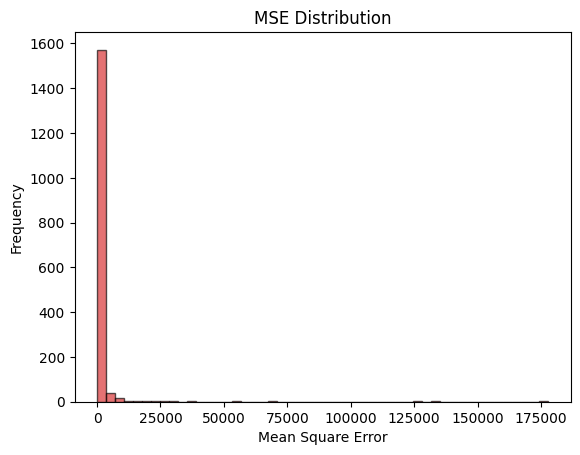

In [ ]:
# Visualize the MSE distribution which follows a one tailed, chisquare dbn
plt.hist(mse_dst,bins=50,color='C3',edgecolor='k', alpha=0.65)
plt.title('MSE Distribution')
plt.xlabel('Mean Square Error')
plt.ylabel('Frequency');
plt.savefig("MSE training distribution LS for real data.tiff", dpi=300)
plt.show();

Find the 95% MSE Upper bound value from the CDF of the MSE distribution and use as a threshold, which is similar to existing NN outlier detection methods.

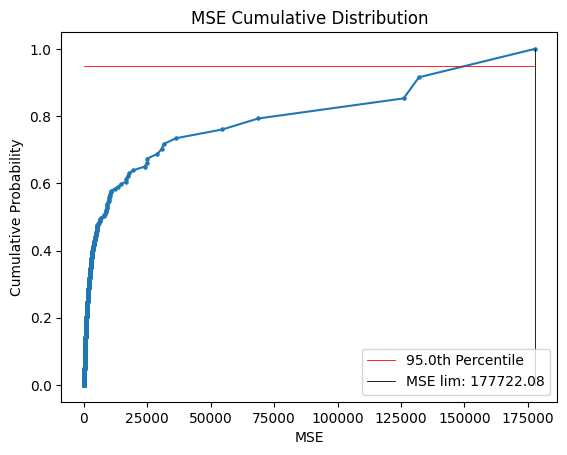

In [ ]:
# Obtain and visualize the 95% MSE value from the CDF of the MSE dbn
sorted_data = np.sort(mse_dst)
cumulative_sum = np.cumsum(sorted_data)

cdf = cumulative_sum / np.sum(sorted_data)

prob_th=0.95
loc_abn=np.where(cdf>prob_th)
abn_mse=sorted_data[loc_abn]
mse_th=abn_mse[0]

# Plot the CDF
plt.scatter(sorted_data, cdf,s=5)
plt.plot(sorted_data, cdf)
plt.plot([0,np.max(mse_dst)],[prob_th,prob_th],color='red',linewidth=0.6,label=str(round(prob_th*100,0))+"th Percentile")
plt.plot([mse_th,mse_th],[0,1],color='black',linewidth=0.6,label='MSE lim: '+str(round(mse_th,2)))
plt.xlabel('MSE')
plt.ylabel('Cumulative Probability')
plt.title('MSE Cumulative Distribution')
plt.legend(loc='lower right')
plt.savefig("MSE LS CDF with threshold for real data.tiff", dpi=300)
plt.show()

Generate abnormal points to be embedded in the existing latent space using the well trained AE-encoder.

Using the MSE threshold on the trained AE as cut off, we visualize the MSE distribution for the abnormal points generated and set points above the MSE threshold to be outliers

In [ ]:
abn_pts=X_n[np.where(mse_dst>=mse_th)] # Obtain and visualize the 95% MSE value from the CDF of the MSE dbn

In [ ]:
abn_latent_space=[]
for i in range(abn_pts.shape[0]):
  test_abn=torch.tensor(abn_pts[i]).to(device)

  lat=model.encoder(test_abn).detach().cpu().numpy()
  abn_latent_space.append(lat)

  pred=model(test_abn).detach().cpu().numpy()
  inv_pred=inv_norm(pred,X)
  inv_test=inv_norm(abn_pts[i],X)

  mse=mean_squared_error(inv_test,inv_pred)

abn_latent_space=np.array(abn_latent_space)

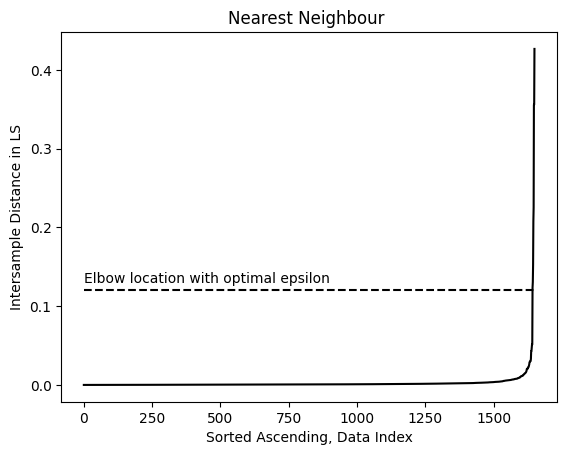

In [ ]:
# Combine inlier and outlier as a single array for the latent space
all_latent_space = np.concatenate((latent_space, abn_latent_space), axis=0)

# Obtain epsilon values for LS if we want to plot it. 
elbow = nearest_neighbor(all_latent_space, [0, 1650], [0.12, 0.12], [0.13,0.13], plotter=True)

Visualize the synthetic datapoints used to train the AE in the latent space as "inliers", while the abnormal points generated and encoded into the same latent space is "noise". Also, the MSE identified outlier points using the threshold/cut-off method is dubbed as "MSE Outliers"

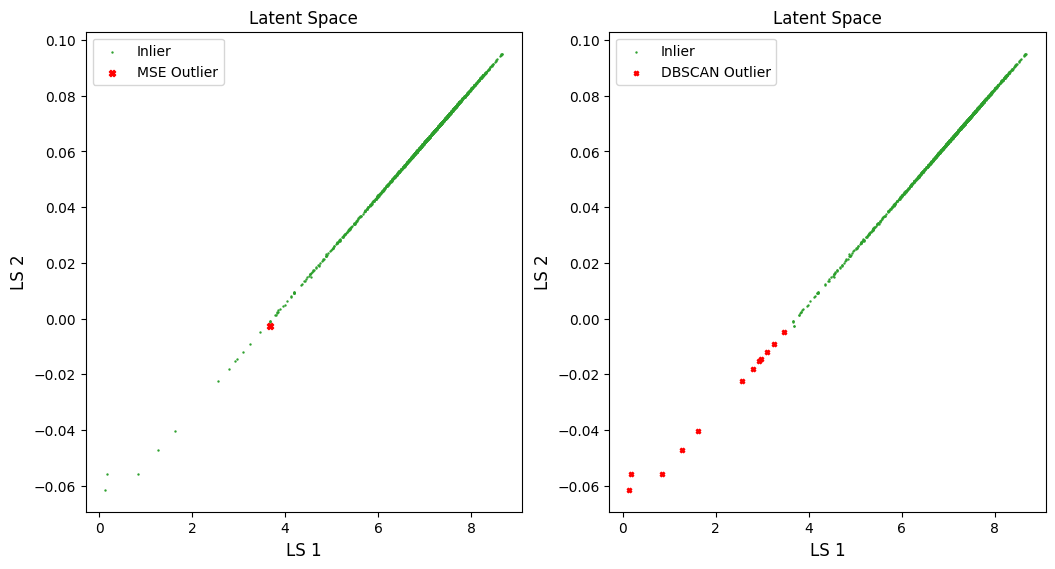

In [ ]:
# Visualize both inliers and true outliers via MSE
plt.subplot(121)
plt.title('Latent Space')
plt.scatter(latent_space[:,0],latent_space[:,1],s=0.5,color='C2',label='Inlier')
plt.scatter(abn_latent_space[:,0],abn_latent_space[:,1],s=20,color='red',marker="X",label='MSE Outlier')
plt.legend()
plt.xlabel('LS 1',fontsize=12)
plt.ylabel('LS 2', fontsize=12);


# Perform DBSCAN to identify outlier in LS
n_clusters = []
df2 = pd.DataFrame(all_latent_space, columns=['LS 1', 'LS 2'])
dbscan = DBSCAN(eps=0.20, min_samples=10).fit(df2.values)
df2['Label'] = dbscan.labels_ + 1

df_in = df2.loc[(df2['Label'] != 0)]
df_outlier = df2.loc[(df2['Label'] == 0)]
number_clusters = len(df_in['Label'].unique())


# Visualize both inliers and outliers via DBSCAN
plt.subplot(122)
plt.title('Latent Space')
plt.scatter(df_in.iloc[:, 0], df_in.iloc[:, 1], c='C2', s=0.5, label='Inlier')
plt.scatter(df_outlier.iloc[:, 0], df_outlier.iloc[:, 1], c='red', s=10, marker='X',label='DBSCAN Outlier')
plt.legend()
plt.xlabel('LS 1',fontsize=12)
plt.ylabel('LS 2', fontsize=12);


plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.0, wspace=0.2, hspace=0.2)
plt.savefig("MSE and DBSCAN in LS for real data.tiff", dpi=300)
plt.show()

# Existing Multivariate Outlier Detection Methodologies

<br>

Let's perform some of the existing methods in literature that works on the identification of Multivariate outliers, but before we proceed let's use pca to reduce the dimension of the data to better aid visulaization of the outliers found using these methods.

1. Isolation Forest (IF)
2. DBSCAN on highdimensional dataset
3. Local outlier factor (LOF)

<br>

For the three methods above, since they are performed on high dimensional dataasts in their original space, visualization is a problem. Hence, we used principal component analysis to reduce the dimensionality to enable visualization using the two most prominent principal component found i.e., PC 1 and PC 2.

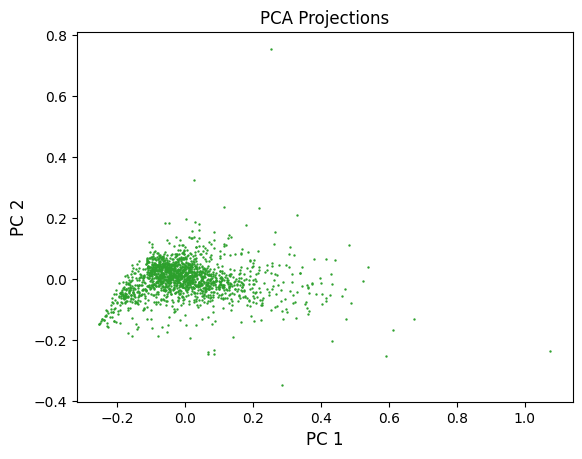

In [ ]:
# Dimensionality reduction to 2 dimensions
data_asis = pd.DataFrame(red_arr, columns=['Qp', 'Tp', 'Pc', 'Qo', 'Qw'])

# Instantiate min max scaler to reduce magintude effects/variation in each predictor
scaler = MinMaxScaler()
data_asis_scaled = scaler.fit_transform(data_asis.values)

pca = PCA(n_components=2) 
real_pca = pca.fit_transform(data_asis_scaled)

#Visualize PCA space with original data
plt.title('PCA Projections')
plt.scatter(real_pca[:,0],real_pca[:,1],s=0.5,color='C2', label='Inlier')
plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12);
plt.savefig("PCA space visualization for real data.tiff", dpi=300)
plt.show();

## Isolation Forest (IF)

In [ ]:
# Isolation forest
# Initialize isolation forest
df_IF = data_asis.copy()
isolation = IsolationForest(n_estimators=100, 
                            contamination='auto', 
                            max_features=df_IF.shape[1], random_state=42)

# Fit and predict
isolation.fit(df_IF.values)
outliers_predicted = isolation.predict(df_IF.values)

# Add outliers to new column
df_IF['outlier'] = outliers_predicted

# Add PC 1 and PC 2 to the df
df_IF['PC 1'] = real_pca[:,0]
df_IF['PC 2'] = real_pca[:,1]

# How many outliers exist in the dataset
df_IF['outlier'].value_counts() 

 1    1460
-1     189
Name: outlier, dtype: int64

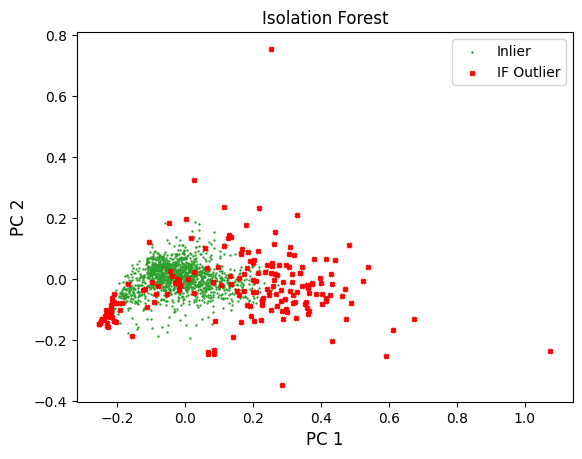

In [ ]:
# Curate inliers and outliers per IF method
inliers = df_IF[df_IF['outlier'] == 1]
outliers = df_IF[df_IF['outlier'] != 1]

# Using the previously found PCA projections, now visualize the IF results
plt.title('Isolation Forest')

plt.scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
plt.scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=10, marker='X',label='IF Outlier')

plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12);
plt.legend(loc='best')
plt.savefig("PCA space visualization for real data using isolation forest.tiff", dpi=300)
plt.show();

## DBSCAN in High Dimensional Space

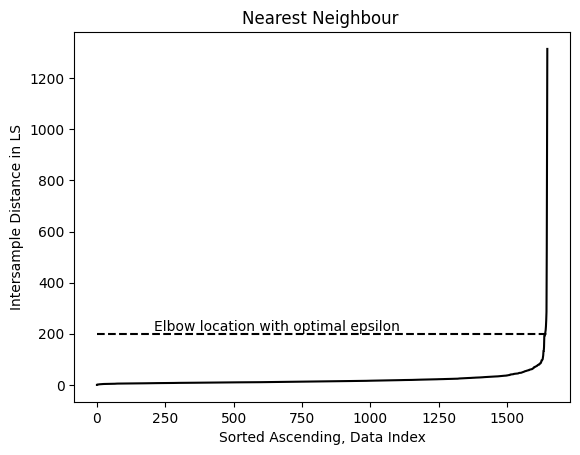

In [ ]:
# Perform DBSCAN on the 5 predictor feature daset and visualize using PCA 
df_DBSCAN = data_asis.copy()

# first we obtain the epsilon parameter to be used
elbow = nearest_neighbor(df_DBSCAN.values ,[0, 1650], [200, 200], [210,210], plotter=True)

In [ ]:
# Perform DBSCAN to identify outlier in PCA projection space
n_clusters = []

dbscan = DBSCAN(eps=200, min_samples=10).fit(df_DBSCAN.values)
df_DBSCAN['DB-Label'] = dbscan.labels_ + 1

# Add PC 1 and PC 2 to the df
df_DBSCAN['PC 1'] = real_pca[:,0]
df_DBSCAN['PC 2'] = real_pca[:,1]


# Separate inlier and outliers
inliers = df_DBSCAN.loc[(df_DBSCAN['DB-Label'] != 0)]
outliers = df_DBSCAN.loc[(df_DBSCAN['DB-Label'] == 0)]
number_clusters = len(inliers['DB-Label'].unique())

# How many outliers exist in the dataset
outliers['DB-Label'].value_counts() 

0    16
Name: DB-Label, dtype: int64

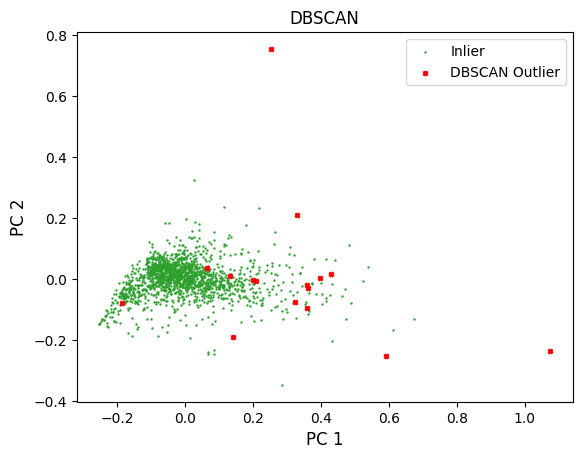

In [ ]:
# Using the previously found PCA projections, now visualize the DBSCAN results
plt.title('DBSCAN')

plt.scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
plt.scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=10, marker='X',label='DBSCAN Outlier')

plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12);
plt.legend(loc='best')
plt.savefig("PCA space visualization for real data using DBSCAN.tiff", dpi=300)
plt.show();

In [ ]:
# Transform data
df_lof = data_asis.copy()

# Instantiate min max scaler to reduce magintude effects/variation in each predictor
scaler = MinMaxScaler()
df_lof_scaled = scaler.fit_transform(df_lof.values)

# Instantiate LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')

# Fit and predict on scaled data
outliers_predicted = lof.fit_predict(df_lof_scaled)

# Put found outliers in new column
df_lof['outlier'] = outliers_predicted

# Add PC 1 and PC 2 to the df
df_lof['PC 1'] = real_pca[:,0]
df_lof['PC 2'] = real_pca[:,1]

# How many outliers are in data 
df_lof['outlier'].value_counts() 

 1    1547
-1     102
Name: outlier, dtype: int64

## Local Outlier Factor (LOF)

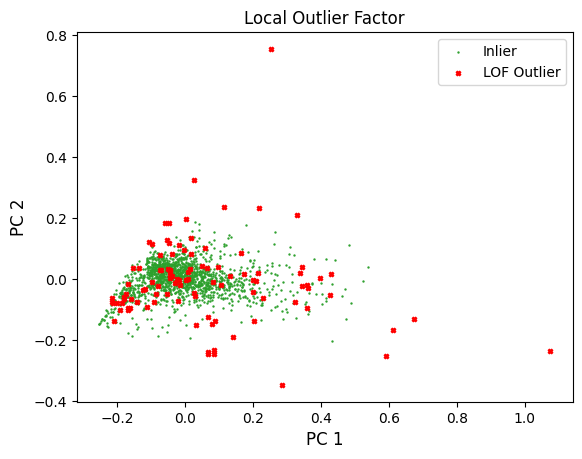

In [ ]:
# Curate inliers and outliers per LOF method
inliers = df_lof[df_lof['outlier'] == 1]
outliers = df_lof[df_lof['outlier'] != 1]

# Using the previously found PCA projections, now visualize the IF results
plt.title('Local Outlier Factor')

plt.scatter(inliers['PC 1'], inliers['PC 2'], c='C2', s=0.5, label='Inlier')
plt.scatter(outliers['PC 1'], outliers['PC 2'], c='red', s=10, marker='X',label='LOF Outlier')

plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12);
plt.legend(loc='best')
plt.savefig("PCA space visualization for real data using local outlier factor.tiff", dpi=300)
plt.show();